In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from scipy.optimize import minimize

# Load Real Data

In [2]:
path = "C:/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt", header=None).values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt", header=None).values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt", header=None).values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [3]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])


HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

In [4]:
# SMOOTHING
BP_data_scaled_averaged = BP_data_scaled.rolling(60).mean()
HR_data_scaled_averaged = HR_data_scaled.rolling(60).mean()

# Loading Model

In [5]:
bs = 64
lr = 0.01
stdev = 0.05
e = 20

original_dim = 32
input_shape = (original_dim, )
intermediate_dim = 16
latent_dim = 8

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), stddev=stdev)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# ENCODER
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = BatchNormalization()(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()

encoder.load_weights("encoder/")

# Generate Baseline Data

In [6]:
def generate_line(a, b, n=32, noise=0):
    x = np.arange(n)
    return a * x + b + np.random.normal(0, noise, n)

def generate_lines(a, bs, n_train, c, lines, labels):
    for b in bs:
        generated_lines = np.array([generate_line(a, b, noise=0.005) for _ in range(int(n_train/16))])
        generated_labels = np.array([c for _ in range(int(n_train/16))])
        if lines.size == 0:
            lines = generated_lines
            labels = generated_labels
        else:
            lines = np.concatenate((lines, generated_lines))
            labels = np.concatenate((labels, generated_labels))
    return lines, labels
    
def generate_lines_set(n_train):    
    lines = np.array([])
    labels = np.array([])

    lines, labels = generate_lines(0, [0, .4, .8, 1.2, 1.6, 2], n_train, 'g', lines, labels)
    lines, labels = generate_lines(0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'r', lines, labels)
    lines, labels = generate_lines(-0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'b', lines, labels)

    return np.array(lines), np.array(labels)

n_lines = 64000
n_types = 16
x_train, y_train = generate_lines_set(64000)

# Calculate Baseline

In [7]:
z_test, _, _ = encoder.predict(x_train, batch_size=bs)
straight_lines_8D = z_test[:24000]
means = straight_lines_8D.mean(axis=0)
principal_axis = np.linalg.svd(straight_lines_8D - means)[2][0]
baseline_point1 = np.array([0,0,0,0,0,0,0,0], np.float32)
baseline_point2 = np.array(principal_axis, np.float32)

In [8]:
def dist(p, q, rs):
    x = p-q
    return np.linalg.norm(
        np.outer(np.dot(rs-q, x)/np.dot(x, x), x)+q-rs,
        axis=1)

# Visualize 2D

# Parameters Optimisation

In [66]:
indexes = ['1', '92', '110', '158', '286', '295', '375', '393', '460', '501', '606', '658', '675']
# indexes = ['375', '393']

In [67]:
def label_func(index, start, end, color):
    for i in range(start, end):
        BP_HR_validation_labels[index][i] = color

BP_HR_validation_labels = dict()
BP_validation = dict()
HR_validation = dict()
for index in indexes:
    BPx = np.array(BP_data_scaled_averaged[index])
    HRx = np.array(HR_data_scaled_averaged[index])
    BPx = BPx[~np.isnan(BPx)]
    HRx = HRx[~np.isnan(HRx)]
    BPx = BPx[:-(BPx.shape[0] % 32)]
    HRx = HRx[:-(HRx.shape[0] % 32)]
    BPxs = np.array(np.array_split(BPx, int(len(BPx)/32)))
    HRxs = np.array(np.array_split(HRx, int(len(HRx)/32)))
    BP_HR_validation_labels[index] = np.array(['g']*len(BPxs))
    BP_validation[index] = BPxs
    HR_validation[index]= HRxs

In [68]:
index = '1'
label_func('1', 80, 81, 'r')
label_func('1', 81, 107, 'r')
label_func('1', 107, 111, 'r')
index = '375'
label_func('375', 40, 47, 'r')
label_func('375', 129, 133, 'r')
label_func('375', 133, 141, 'r')
label_func('375', 141, 144, 'r')
label_func('375', 162, 168, 'r')
index = '393' 
label_func('393', 31, 32, 'r')
label_func('393', 32, 36, 'r')
label_func('393', 36, 37, 'r')
index = '92' 
label_func('92', 41, 49, 'r')
label_func('92', 140, 143, 'r')
label_func('92', 143, 154, 'r')
index = '110' 
label_func('110', 119, 120, 'r')
label_func('110', 120, 123, 'r')
label_func('110', 123, 125, 'r')
index = '158' 
label_func('158', 24, 28, 'r')
label_func('158', 115, 116, 'r')
label_func('158', 116, 122, 'r')
label_func('158', 122, 123, 'r')
index = '286' 
label_func('286', 61, 62, 'r')
label_func('286', 62, 65, 'r')
label_func('286', 65, 67, 'r')
label_func('286', 123, 124, 'r')
label_func('286', 124, 129, 'r')
label_func('286', 129, 131, 'r')
label_func('286', 131, 134, 'r')
index = '295' 
label_func('295', 131, 134, 'r')
label_func('295', 134, 144, 'r')

index = '460' 
label_func('460', 49, 50, 'r')
label_func('460', 50, 58, 'r')
label_func('460', 58, 59, 'r')
index = '501'
label_func('501', 119, 120, 'r')
label_func('501', 120, 124, 'r')
label_func('501', 124, 125, 'r')
index = '606'
label_func('606', 59, 61, 'r')
label_func('606', 61, 70, 'r')
label_func('606', 70, 72, 'r')
index = '658', 
label_func('658', 35, 36, 'r')
label_func('658', 36, 53, 'r')
label_func('658', 53, 55, 'r')
index ='675', 
label_func('675', 80, 82, 'r')
label_func('675', 82, 101, 'r')
label_func('675', 101, 104, 'r')

In [83]:
# liczyc srednia rkoczaca n-elementowa i sprawdzac czy ona wykracza poza threshold i czy aktualny element wyrkacza, jesli oba 
# to czerwien jesli jedno to zolty
severity_acc = np.array([0,0,0,0,0,0,0,0])

def check_severity(HR_line_8D, BP_line_8D, a, b):
    global severity_acc
    distance = sum(dist(baseline_point1, baseline_point2, np.array([BP_line_8D[0], HR_line_8D[0]])))
    severity_acc = np.append(severity_acc, distance)
    averaged_distance = severity_acc[-3:].mean()
    anomaly_score = distance + averaged_distance
    
    if distance > a:
        return 'r'
    if averaged_distance > b:
        return 'r'
    return 'g'
    

In [84]:
def sample_timeseries(x):
    x = np.array(x)
    x = x[~np.isnan(x)]
    if x.shape[0] % 32 != 0:
        x = x[:-(x.shape[0] % 32)]
    return np.array(np.array_split(x, int(len(x)/32)))

In [85]:
def funkcja(params):
    start = time.time()
    a, b = params
    global severity_acc
    counter = 0
    correct = 0
    for i in indexes:
        HR = sample_timeseries(HR_data_scaled_averaged[i])
        BP = sample_timeseries(BP_data_scaled_averaged[i])
        severity_acc = np.array([0,0,0,0,0,0,0,0])   
        for HRv, BPv, label in zip(HR, BP, BP_HR_validation_labels[i]):
            BP_line_8D, _, _ = encoder.predict(np.array([BPv]))
            HR_line_8D, _, _ = encoder.predict(np.array([HRv]))
            severity = check_severity(HR_line_8D, BP_line_8D, a, b)
            if severity == label:
                correct += 1
            counter += 1
    print(f"Accuracy: {(correct/counter):.3f}, a: {a:.3f}, b: {b:.3f}, time:{(time.time() - start):.2f}s")
    return 1 - (correct / counter)

In [74]:
aa = np.array(range(50, 155, 5)) / 1000
bb = np.array(range(50, 155, 5)) / 1000
len(aa)

21

In [86]:
for b in bb:
    for a in aa:
        funkcja([a, b])
# x0 = [0.05, 0.05]
# res = minimize(funkcja, x0, method='Nelder-Mead', tol=1e-4)

Accuracy: 0.673, a: 0.050, b: 0.050, time:91.39s
Accuracy: 0.748, a: 0.055, b: 0.050, time:92.85s
Accuracy: 0.773, a: 0.060, b: 0.050, time:92.31s
Accuracy: 0.781, a: 0.065, b: 0.050, time:94.50s
Accuracy: 0.783, a: 0.070, b: 0.050, time:91.99s
Accuracy: 0.783, a: 0.075, b: 0.050, time:91.75s
Accuracy: 0.784, a: 0.080, b: 0.050, time:91.56s
Accuracy: 0.784, a: 0.085, b: 0.050, time:92.60s
Accuracy: 0.785, a: 0.090, b: 0.050, time:90.63s
Accuracy: 0.785, a: 0.095, b: 0.050, time:92.75s
Accuracy: 0.785, a: 0.100, b: 0.050, time:94.85s
Accuracy: 0.785, a: 0.105, b: 0.050, time:94.55s
Accuracy: 0.785, a: 0.110, b: 0.050, time:92.77s
Accuracy: 0.785, a: 0.115, b: 0.050, time:94.71s
Accuracy: 0.785, a: 0.120, b: 0.050, time:94.20s
Accuracy: 0.785, a: 0.125, b: 0.050, time:130.73s
Accuracy: 0.785, a: 0.130, b: 0.050, time:106.14s
Accuracy: 0.785, a: 0.135, b: 0.050, time:90.91s
Accuracy: 0.785, a: 0.140, b: 0.050, time:91.68s
Accuracy: 0.785, a: 0.145, b: 0.050, time:90.70s
Accuracy: 0.785, a

Accuracy: 0.725, a: 0.050, b: 0.090, time:95.73s
Accuracy: 0.828, a: 0.055, b: 0.090, time:99.32s
Accuracy: 0.868, a: 0.060, b: 0.090, time:105.96s
Accuracy: 0.882, a: 0.065, b: 0.090, time:101.16s
Accuracy: 0.886, a: 0.070, b: 0.090, time:94.26s
Accuracy: 0.888, a: 0.075, b: 0.090, time:95.39s
Accuracy: 0.885, a: 0.080, b: 0.090, time:94.22s
Accuracy: 0.880, a: 0.085, b: 0.090, time:94.00s
Accuracy: 0.879, a: 0.090, b: 0.090, time:92.41s
Accuracy: 0.876, a: 0.095, b: 0.090, time:93.79s
Accuracy: 0.876, a: 0.100, b: 0.090, time:92.08s
Accuracy: 0.873, a: 0.105, b: 0.090, time:94.59s
Accuracy: 0.873, a: 0.110, b: 0.090, time:92.37s
Accuracy: 0.872, a: 0.115, b: 0.090, time:91.81s
Accuracy: 0.871, a: 0.120, b: 0.090, time:93.78s
Accuracy: 0.871, a: 0.125, b: 0.090, time:100.49s
Accuracy: 0.871, a: 0.130, b: 0.090, time:97.19s
Accuracy: 0.871, a: 0.135, b: 0.090, time:95.47s
Accuracy: 0.871, a: 0.140, b: 0.090, time:93.12s
Accuracy: 0.871, a: 0.145, b: 0.090, time:93.27s
Accuracy: 0.871, 

Accuracy: 0.725, a: 0.050, b: 0.130, time:88.06s
Accuracy: 0.828, a: 0.055, b: 0.130, time:88.14s
Accuracy: 0.867, a: 0.060, b: 0.130, time:87.90s
Accuracy: 0.882, a: 0.065, b: 0.130, time:88.48s
Accuracy: 0.885, a: 0.070, b: 0.130, time:87.74s
Accuracy: 0.886, a: 0.075, b: 0.130, time:88.75s
Accuracy: 0.884, a: 0.080, b: 0.130, time:87.42s
Accuracy: 0.878, a: 0.085, b: 0.130, time:88.84s
Accuracy: 0.876, a: 0.090, b: 0.130, time:87.36s
Accuracy: 0.873, a: 0.095, b: 0.130, time:88.89s
Accuracy: 0.872, a: 0.100, b: 0.130, time:87.46s
Accuracy: 0.868, a: 0.105, b: 0.130, time:88.62s
Accuracy: 0.868, a: 0.110, b: 0.130, time:87.80s
Accuracy: 0.866, a: 0.115, b: 0.130, time:88.76s
Accuracy: 0.865, a: 0.120, b: 0.130, time:87.96s
Accuracy: 0.865, a: 0.125, b: 0.130, time:88.08s
Accuracy: 0.865, a: 0.130, b: 0.130, time:88.19s
Accuracy: 0.865, a: 0.135, b: 0.130, time:87.99s
Accuracy: 0.865, a: 0.140, b: 0.130, time:88.51s
Accuracy: 0.865, a: 0.145, b: 0.130, time:88.05s
Accuracy: 0.864, a: 

<IPython.core.display.Javascript object>


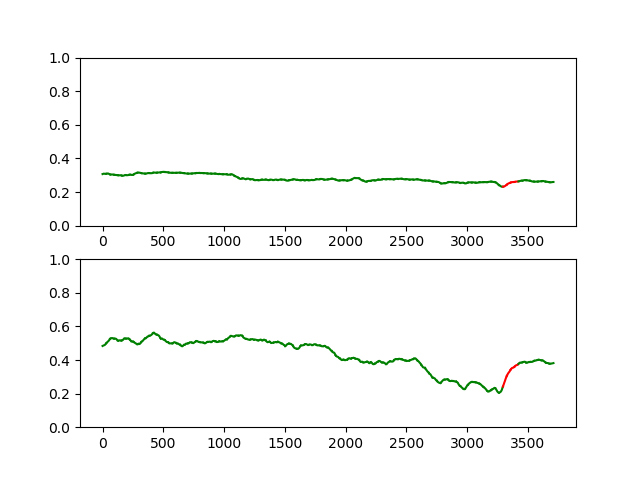

In [82]:
%matplotlib notebook
plt.ion()

n = '1'
HR = sample_timeseries(HR_data_scaled_averaged[n])
BP = sample_timeseries(BP_data_scaled_averaged[n])

# pca = PCA(n_components=2)
# lines_8D, _, _ = encoder.predict(x_train)
# pca.fit(lines_8D)
# lines_2D = pca.transform(lines_8D)

fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.set_ylim(0,1)
ax2 = fig1.add_subplot(212)
ax2.set_ylim(0,1)
# ax3 = fig1.add_subplot(313)
# ax3.scatter(lines_2D[:, 0], lines_2D[:, 1], c=y_train)
t = 0
severity_acc = np.array([0,0,0])
BP_last_elem = None
for HRv, BPv in zip(HR, BP):
    if BP_last_elem == None:
        BP_line_8D, _, _ = encoder.predict(np.array([BPv]))
        HR_line_8D, _, _ = encoder.predict(np.array([HRv]))
        c = check_severity(HR_line_8D, BP_line_8D, 0.185, 0.060)
#         BP_HR_lines_2D = pca.transform([BP_line_8D[0], HR_line_8D[0]])

        ax1.plot(range(t, t + len(HRv)), HRv, color=f'{c}', linestyle='-')
        ax2.plot(range(t, t + len(BPv)), BPv, color=f'{c}', linestyle='-')
#         ax3.scatter(BP_HR_lines_2D[:, 0], BP_HR_lines_2D[:, 1], c=c)

        t += len(BPv)
    else:
        BP_line_8D, _, _ = encoder.predict(np.array([BPv]))
        HR_line_8D, _, _ = encoder.predict(np.array([HRv]))
        c = check_severity(HR_line_8D, BP_line_8D, 0.185, 0.060)
#         BP_HR_lines_2D = pca.transform([BP_line_8D[0], HR_line_8D[0]])

        time_range = range(t-1, t + len(BPv)) 
        BPv = np.concatenate(([BP_last_elem], BPv))
        HRv = np.concatenate(([HR_last_elem], HRv))
        ax1.plot(time_range, HRv, color=f'{c}', linestyle='-')
        ax2.plot(time_range, BPv, color=f'{c}', linestyle='-')
#         ax3.scatter(BP_HR_lines_2D[:, 0], BP_HR_lines_2D[:, 1], c=c)

        t += len(BPv) - 1
    fig1.canvas.draw()
    BP_last_elem = BPv[-1]
    HR_last_elem = HRv[-1] 